In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from pytorch_tabnet.tab_model import TabNetClassifier
from tqdm import tqdm
from sklearn.metrics import f1_score ,roc_auc_score
import time
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import lightgbm as lgb

In [2]:
path = '/Data2/folder_ti/data/'
train_csv = '1st_1011_train.csv'

train = pd.read_csv(path+train_csv,index_col=0)
train = train.astype({'rehabilitation':'object'})


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 728862 entries, 83603 to 518912
Data columns (total 27 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   application_id             728862 non-null  int64  
 1   user_id                    728862 non-null  int64  
 2   purpose                    728862 non-null  object 
 3   is_applied                 728862 non-null  object 
 4   past.is_applied            728862 non-null  int64  
 5   m_past.is_applied          728862 non-null  float64
 6   seq                        728862 non-null  float64
 7   min.loan_rate              728862 non-null  float64
 8   product_n                  728862 non-null  int64  
 9   n.limit_over_desire        728862 non-null  int64  
 10  loan_limit_min.rate        728862 non-null  float64
 11  age                        728862 non-null  int64  
 12  gender                     728862 non-null  int64  
 13  credit_score             

In [4]:
train.head()

,application_id,user_id,purpose,is_applied,past.is_applied,m_past.is_applied,seq,min.loan_rate,product_n,n.limit_over_desire,...,employment_type,houseown_type,desired_amount,rehabilitation,existing_loan_cnt,logdata,diff,diff2,limit_over_desire_product,yd
83603,248576,9,사업자금,노대출,-1,0.465641,0.0,4.3,26,15,...,계약직,기타가족소유,15000000.0,2,1,3,0.0,0.000000,0.807692,0.517241
396875,1180616,11,생활비,대출,-1,0.465641,0.0,10.0,25,15,...,정규직,기타가족소유,2000000.0,-1,1,12,-1000000.0,-0.500000,0.960000,0.080000
588684,1751522,11,대환대출,대출,1,1.000000,1.0,10.7,25,15,...,정규직,기타가족소유,13000000.0,-1,1,21,31000000.0,2.384615,0.680000,0.520000
507188,1508745,14,대환대출,노대출,-1,0.465641,0.0,13.7,2,0,...,정규직,전월세,30000000.0,-1,0,8,-3000000.0,-0.100000,0.000000,1.111111
669142,1990215,17,생활비,대출,-1,0.465641,0.0,17.9,2,2,...,계약직,기타가족소유,3000000.0,-1,0,20,26000000.0,2.835714,1.000000,0.060000


In [5]:
def trans(x):
    if x == '노대출':
        return 0
    elif x == '대출':
        return 1
train['is_applied'] = train['is_applied'].apply(trans)

In [6]:
train.head()

,application_id,user_id,purpose,is_applied,past.is_applied,m_past.is_applied,seq,min.loan_rate,product_n,n.limit_over_desire,...,employment_type,houseown_type,desired_amount,rehabilitation,existing_loan_cnt,logdata,diff,diff2,limit_over_desire_product,yd
83603,248576,9,사업자금,0,-1,0.465641,0.0,4.3,26,15,...,계약직,기타가족소유,15000000.0,2,1,3,0.0,0.000000,0.807692,0.517241
396875,1180616,11,생활비,1,-1,0.465641,0.0,10.0,25,15,...,정규직,기타가족소유,2000000.0,-1,1,12,-1000000.0,-0.500000,0.960000,0.080000
588684,1751522,11,대환대출,1,1,1.000000,1.0,10.7,25,15,...,정규직,기타가족소유,13000000.0,-1,1,21,31000000.0,2.384615,0.680000,0.520000
507188,1508745,14,대환대출,0,-1,0.465641,0.0,13.7,2,0,...,정규직,전월세,30000000.0,-1,0,8,-3000000.0,-0.100000,0.000000,1.111111
669142,1990215,17,생활비,1,-1,0.465641,0.0,17.9,2,2,...,계약직,기타가족소유,3000000.0,-1,0,20,26000000.0,2.835714,1.000000,0.060000


In [7]:
train.is_applied.value_counts()

1    377534
0    351328
Name: is_applied, dtype: int64

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 728862 entries, 83603 to 518912
Data columns (total 27 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   application_id             728862 non-null  int64  
 1   user_id                    728862 non-null  int64  
 2   purpose                    728862 non-null  object 
 3   is_applied                 728862 non-null  int64  
 4   past.is_applied            728862 non-null  int64  
 5   m_past.is_applied          728862 non-null  float64
 6   seq                        728862 non-null  float64
 7   min.loan_rate              728862 non-null  float64
 8   product_n                  728862 non-null  int64  
 9   n.limit_over_desire        728862 non-null  int64  
 10  loan_limit_min.rate        728862 non-null  float64
 11  age                        728862 non-null  int64  
 12  gender                     728862 non-null  int64  
 13  credit_score             

In [9]:
data_0 = train[train.is_applied == 0]
data_1 = train[train.is_applied == 1]
target = 'is_applied'    
if "set" not in data_0.columns:
    data_0["set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(data_0.shape[0],))
if "set" not in data_1.columns:
    data_1["set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(data_1.shape[0],))

/tmp/ipykernel_39107/2034989029.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_0["set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(data_0.shape[0],))
/tmp/ipykernel_39107/2034989029.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1["set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(data_1.shape[0],))


In [10]:
train = pd.concat([data_0,data_1], ignore_index=True)
train=train.sample(frac=1).reset_index(drop=True)

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728862 entries, 0 to 728861
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   application_id             728862 non-null  int64  
 1   user_id                    728862 non-null  int64  
 2   purpose                    728862 non-null  object 
 3   is_applied                 728862 non-null  int64  
 4   past.is_applied            728862 non-null  int64  
 5   m_past.is_applied          728862 non-null  float64
 6   seq                        728862 non-null  float64
 7   min.loan_rate              728862 non-null  float64
 8   product_n                  728862 non-null  int64  
 9   n.limit_over_desire        728862 non-null  int64  
 10  loan_limit_min.rate        728862 non-null  float64
 11  age                        728862 non-null  int64  
 12  gender                     728862 non-null  int64  
 13  credit_score               72

In [12]:
train = train.astype({'rehabilitation':'object','gender':'object'})
train_ = train

In [13]:
train.rehabilitation.value_counts()

-1    416644
 2    309468
 0      2372
 1       378
Name: rehabilitation, dtype: int64

In [14]:
cat_col = ['purpose','income_type','rehabilitation','gender','employment_type','houseown_type']

In [15]:
cat_trans = dict()
for cat in cat_col :
    cat_trans[cat] = dict()
    type_ = list(set(train[cat].tolist()))
    for i, ty in enumerate(type_) :
        cat_trans[cat][ty] = i

In [16]:
cat_trans

{'purpose': {'기타': 0,
  '자동차구입': 1,
  '투자': 2,
  '전월세보증금': 3,
  '생활비': 4,
  '사업자금': 5,
  '주택구입': 6,
  '대환대출': 7},
 'income_type': {'PRIVATEBUSINESS': 0,
  'EARNEDINCOME2': 1,
  'OTHERINCOME': 2,
  'FREELANCER': 3,
  'EARNEDINCOME': 4,
  'PRACTITIONER': 5},
 'rehabilitation': {0: 0, 1: 1, 2: 2, -1: 3},
 'gender': {0: 0, 1: 1, -1: 2},
 'employment_type': {'기타': 0, '정규직': 1, '일용직': 2, '계약직': 3},
 'houseown_type': {'전월세': 0, '배우자': 1, '자가': 2, '기타가족소유': 3}}

In [17]:
from tqdm import tqdm
for cat in cat_col :
    if cat == 'gender' :
        continue
    for k in tqdm(cat_trans[cat].keys()) :
        train[cat][train[cat]==k] = cat_trans[cat][k]   

  0%|                                                                                                                       | 0/8 [00:00<?, ?it/s]/tmp/ipykernel_39107/4081748353.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[cat][train[cat]==k] = cat_trans[cat][k]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 17.94it/s]


In [18]:
train_indices = train[train.set=="train"].index
valid_indices = train[train.set=="valid"].index
test_indices = train[train.set=="test"].index

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728862 entries, 0 to 728861
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   application_id             728862 non-null  int64  
 1   user_id                    728862 non-null  int64  
 2   purpose                    728862 non-null  object 
 3   is_applied                 728862 non-null  int64  
 4   past.is_applied            728862 non-null  int64  
 5   m_past.is_applied          728862 non-null  float64
 6   seq                        728862 non-null  float64
 7   min.loan_rate              728862 non-null  float64
 8   product_n                  728862 non-null  int64  
 9   n.limit_over_desire        728862 non-null  int64  
 10  loan_limit_min.rate        728862 non-null  float64
 11  age                        728862 non-null  int64  
 12  gender                     728862 non-null  object 
 13  credit_score               72

In [20]:
types = train.dtypes
target = 'is_applied'
unused_col = ['set','user_id','application_id']
cat_col = ['purpose','income_type','rehabilitation','gender','employment_type','houseown_type']

features = [ col for col in train.columns if col not in unused_col+[target]] 

In [21]:
#nunique = train.nunique()
types = train.dtypes
target = 'is_applied'
unused_col = ['set','user_id','application_id']
cat_col = ['purpose','income_type','rehabilitation','gender','employment_type','houseown_type']
categorical_dims =  {}
for col in train.columns:
    if col in cat_col :
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_dims[col] = len(l_enc.classes_)
    elif col not in unused_col+[target]:
        train.fillna(train.loc[:, col].mean(), inplace=True)


# Categorical Embedding을 위해 Categorical 변수의 차원과 idxs를 담음.
features = [ col for col in train.columns if col not in unused_col+[target]] 
cat_idxs = [ i for i, f in enumerate(features) if f in cat_col]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in cat_col]
#train_shuf = train_shuf.astype({'income_type':'int64','employment_type':'int64','houseown_type':'int64','purpose':'int64'})

purpose 8
gender 3
income_type 6
employment_type 4
houseown_type 4
rehabilitation 4


In [22]:
train.head()

,application_id,user_id,purpose,is_applied,past.is_applied,m_past.is_applied,seq,min.loan_rate,product_n,n.limit_over_desire,...,houseown_type,desired_amount,rehabilitation,existing_loan_cnt,logdata,diff,diff2,limit_over_desire_product,yd,set
0,1500994,190932,5,0,-1,0.465641,0.0,13.7,1,0,...,1,60000000.0,3,8,34,-57000000.0,-0.950000,0.000000,0.937500,train
1,1696860,545518,2,0,-1,0.465641,0.0,6.9,14,0,...,1,64500000.0,3,0,6,-54500000.0,-0.844961,0.000000,0.806250,train
2,1258933,67873,7,1,-1,0.465641,0.0,10.0,21,0,...,0,64500000.0,3,6,10,-9500000.0,-0.147287,0.000000,0.750000,test
3,805470,280900,1,0,0,0.000000,1.0,6.7,33,15,...,0,30000000.0,2,3,0,40000000.0,1.333333,0.727273,0.348837,test
4,421178,554347,5,1,1,1.000000,1.0,13.9,2,0,...,1,15000000.0,2,5,34,-9000000.0,-0.600000,0.000000,2.024601,train


In [23]:
features

['purpose',
 'past.is_applied',
 'm_past.is_applied',
 'seq',
 'min.loan_rate',
 'product_n',
 'n.limit_over_desire',
 'loan_limit_min.rate',
 'age',
 'gender',
 'credit_score',
 'yearly_income',
 'income_type',
 'company_year',
 'employment_type',
 'houseown_type',
 'desired_amount',
 'rehabilitation',
 'existing_loan_cnt',
 'logdata',
 'diff',
 'diff2',
 'limit_over_desire_product',
 'yd']

In [24]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [25]:
import torch
DEVICE = 'cuda:4' if torch.cuda.is_available() else 'cpu'
print("Using {}".format(DEVICE))

Using cuda:4


In [26]:
params = {'n_d' : 64,
         'n_steps' :5,        # tree에 depth
         'gamma':1.5,
         'n_independent':2,
          'cat_idxs':cat_idxs,
          'cat_dims':cat_dims,
         'n_shared':2,
         'cat_emb_dim':1,
         'lambda_sparse':1e-4,
         'momentum':0.3,
         'clip_value':2.,
         'optimizer_fn':torch.optim.Adam,
         'optimizer_params':dict(lr=2e-2),
         'scheduler_params':{"gamma": 0.95,
                         "step_size": 20},
         'scheduler_fn':torch.optim.lr_scheduler.StepLR,
         'epsilon':1e-15,
         'device_name':DEVICE,
         'mask_type':'sparsemax'}

clf = TabNetClassifier(**params
)
s = time.time()

clf.fit(X_train=X_train, y_train=y_train,eval_set=[(X_valid, y_valid)],
    max_epochs=50 , patience=20,
    batch_size=10240, virtual_batch_size=1280,
    num_workers=0,
    weights=1,
    drop_last=False
)

print('TabNet gpu sec : ',time.time()- s)


pred_valid = clf.predict(X_valid)
pred_test = clf.predict(X_test)


f1_valid = f1_score(y_valid, pred_valid) # y_true : 정답 값, y_pred : 예측 값 
f1_test = f1_score(y_test, pred_test)
print("Valid F1 score: {}".format(f1_valid))
print("Test F1 score: {}".format(f1_test))
 

from sklearn.metrics import roc_auc_score 
roc_auc = roc_auc_score(y_valid, pred_valid)
roc_auc_t = roc_auc_score(y_test, pred_test) 
print("Valid ROC AUC Score: {}".format(roc_auc))
print("Test ROC AUC Score: {}".format(roc_auc_t))

/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda:4
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.74467 | val_0_auc: 0.52675 |  0:00:16s
epoch 1  | loss: 0.63717 | val_0_auc: 0.66501 |  0:00:32s
epoch 2  | loss: 0.6341  | val_0_auc: 0.68443 |  0:00:51s
epoch 3  | loss: 0.62833 | val_0_auc: 0.69339 |  0:01:09s
epoch 4  | loss: 0.62803 | val_0_auc: 0.70215 |  0:01:28s
epoch 5  | loss: 0.62534 | val_0_auc: 0.70541 |  0:01:46s
epoch 6  | loss: 0.6246  | val_0_auc: 0.70805 |  0:02:05s
epoch 7  | loss: 0.62239 | val_0_auc: 0.70806 |  0:02:23s
epoch 8  | loss: 0.62165 | val_0_auc: 0.70882 |  0:02:39s
epoch 9  | loss: 0.6219  | val_0_auc: 0.71145 |  0:02:55s
epoch 10 | loss: 0.6224  | val_0_auc: 0.70681 |  0:03:12s
epoch 11 | loss: 0.62197 | val_0_auc: 0.71189 |  0:03:31s
epoch 12 | loss: 0.61868 | val_0_auc: 0.71548 |  0:03:49s
epoch 13 | loss: 0.61762 | val_0_auc: 0.71428 |  0:04:08s
epoch 14 | loss: 0.61771 | val_0_auc: 0.71431 |  0:04:27s
epoch 15 | loss: 0.6177  | val_0_auc: 0.71733 |  0:04:44s
epoch 16 | loss: 0.61651 | val_0_auc: 0.71715 |  0:05:01s
epoch 17 | los

/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet gpu sec :  899.5038793087006
Valid F1 score: 0.6963427109974425
Test F1 score: 0.6952974678673132
Valid ROC AUC Score: 0.6716838275004561
Test ROC AUC Score: 0.6723662646004556


### final 1차 데이터 gender, employment_type, houseown_type 뺀 최고 성능 =0.66(thres 전), =0.71(thres 후)

### final 1차 데이터 gender, employment_type, houseown_type 포함 최고 성능 =0.69(thres 전), =0.723(thres 후)


In [23]:

clf = TabNetClassifier(n_d=64, n_a=64, n_steps=5,
                       gamma=1.5, n_independent=2, n_shared=2,
                       cat_emb_dim=1, cat_idxs = cat_idxs, 
                           cat_dims = cat_dims, lambda_sparse=1e-4, 
                       momentum=0.3, clip_value=2., optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2), scheduler_params = {"gamma": 0.95,
                         "step_size": 20},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15,
                       device_name = DEVICE
)
s = time.time()

clf.fit(X_train=X_train, y_train=y_train,eval_set=[(X_valid, y_valid)],
    max_epochs=10 , patience=20,
    batch_size=10240, virtual_batch_size=1280,
    num_workers=0,
    weights=1,
    drop_last=False
)

print('TabNet gpu sec : ',time.time()- s)


pred_valid = clf.predict(X_valid)
pred_test = clf.predict(X_test)


f1_valid = f1_score(y_valid, pred_valid) # y_true : 정답 값, y_pred : 예측 값 
f1_test = f1_score(y_test, pred_test)
print("Valid F1 score: {}".format(f1_valid))
print("Test F1 score: {}".format(f1_test))
 

from sklearn.metrics import roc_auc_score 
roc_auc = roc_auc_score(y_valid, pred_valid)
roc_auc_t = roc_auc_score(y_test, pred_test) 
print("Valid ROC AUC Score: {}".format(roc_auc))
print("Test ROC AUC Score: {}".format(roc_auc_t))

/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda:1
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.78989 | val_0_auc: 0.53349 |  0:00:11s
epoch 1  | loss: 0.66931 | val_0_auc: 0.59798 |  0:00:23s
epoch 2  | loss: 0.66664 | val_0_auc: 0.61497 |  0:00:35s
epoch 3  | loss: 0.66352 | val_0_auc: 0.64423 |  0:00:47s
epoch 4  | loss: 0.65989 | val_0_auc: 0.64698 |  0:00:59s
epoch 5  | loss: 0.65716 | val_0_auc: 0.65316 |  0:01:11s
epoch 6  | loss: 0.65546 | val_0_auc: 0.65554 |  0:01:23s
epoch 7  | loss: 0.65507 | val_0_auc: 0.65586 |  0:01:35s
epoch 8  | loss: 0.65376 | val_0_auc: 0.65899 |  0:01:47s
epoch 9  | loss: 0.65189 | val_0_auc: 0.66078 |  0:01:59s
Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_val_0_auc = 0.66078


/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet gpu sec :  131.33114910125732
Valid F1 score: 0.5916773516726891
Test F1 score: 0.5967084707203639
Valid ROC AUC Score: 0.6197407370506696
Test ROC AUC Score: 0.6224825902642892


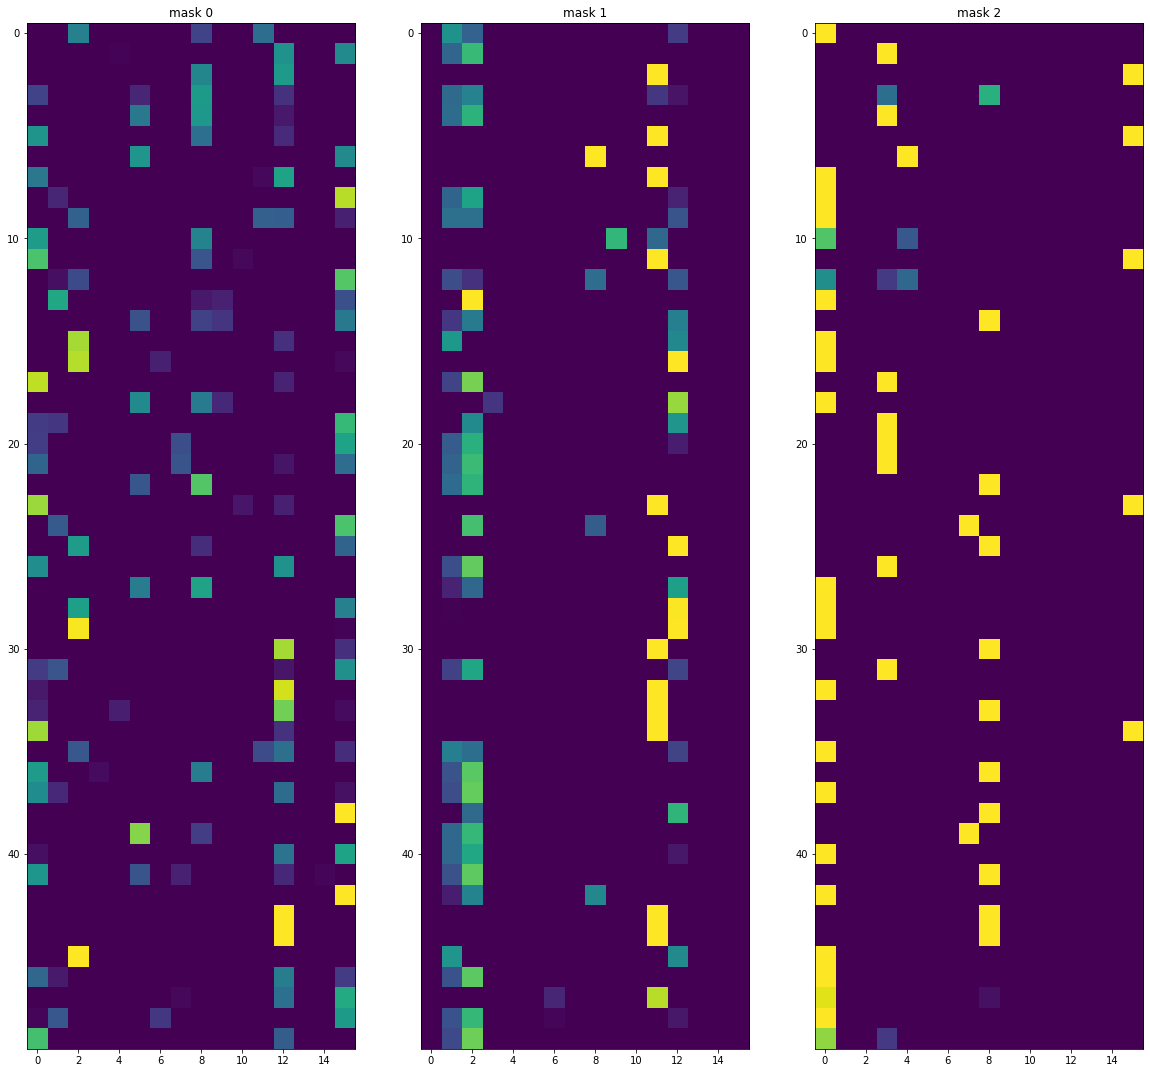

In [24]:
from matplotlib import pyplot as plt
explain_matrix, masks = clf.explain(X_test)

fig, axs = plt.subplots(1, 3, figsize=(20,20))
for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

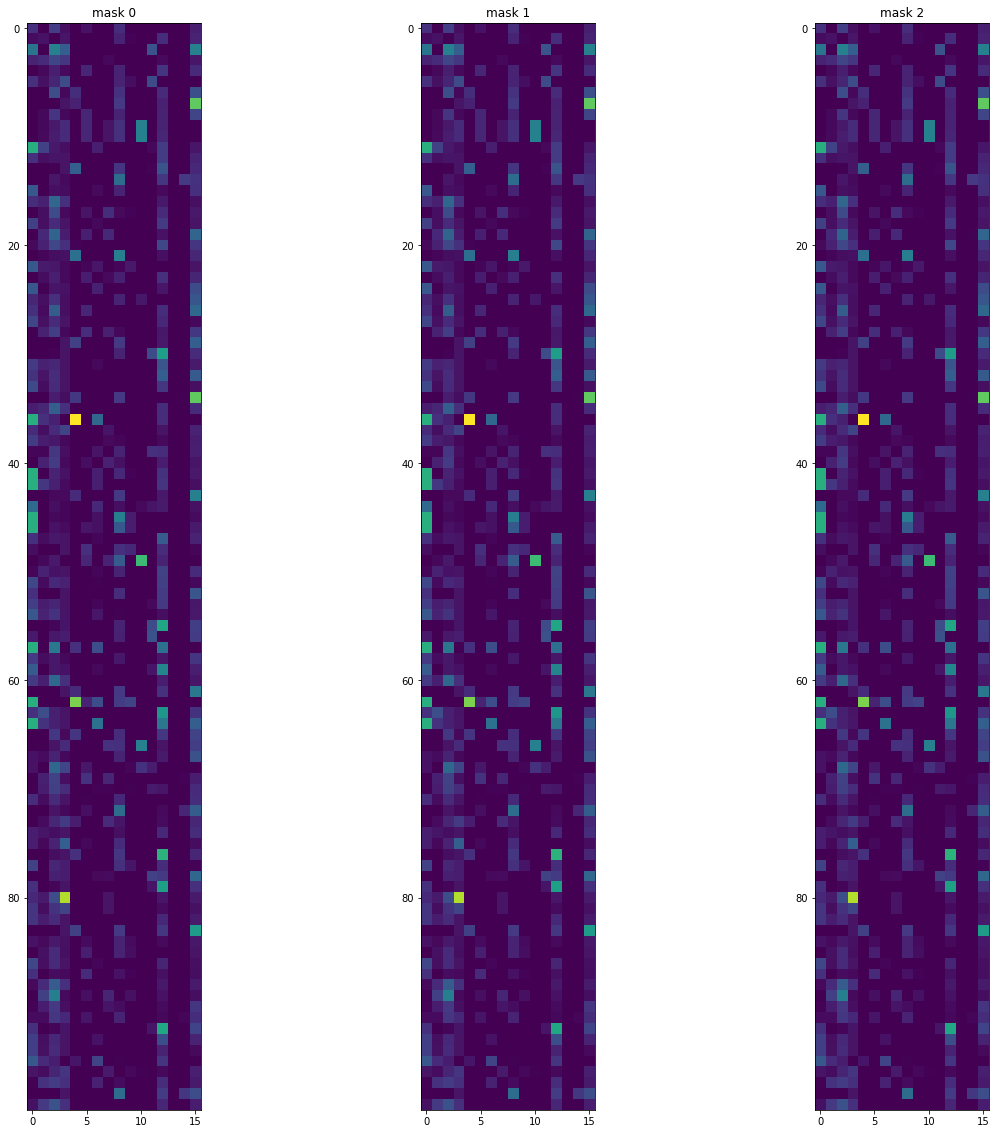

In [40]:
#explain_matrix
fig, axs = plt.subplots(1, 3, figsize=(20,20))
for i in range(3):
    axs[i].imshow(explain_matrix[y_idx[0][:100],:])
    axs[i].set_title(f"mask {i}")

In [25]:
explain_matrix.shape

(73101, 16)

In [34]:
y_idx = np.where(y_test==1)

In [38]:
y_idx

(array([41791, 41792, 41793, ..., 73098, 73099, 73100]),)

In [37]:
len(y_idx[0])

31310

In [41]:
importance = np.mean(explain_matrix,axis = 0)
print(importance.shape)

(16,)


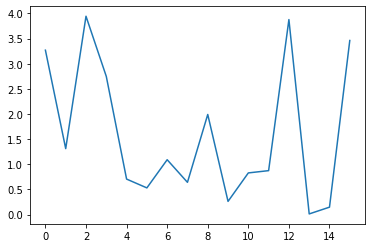

In [42]:
plt.plot(importance)

In [43]:
features

['purpose',
 'past.is_applied',
 'm_past.is_applied',
 'seq',
 'age',
 'gender',
 'credit_score',
 'yearly_income',
 'income_type',
 'company_year',
 'employment_type',
 'houseown_type',
 'desired_amount',
 'rehabilitation',
 'existing_loan_cnt',
 'logdata']

In [45]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_valid, pred_valid))

print(confusion_matrix(y_test, pred_test))

[[24802 17362]
 [10898 20506]]
[[24531 17186]
 [10812 20566]]


In [47]:
pred_valid

array([1, 1, 0, ..., 1, 1, 1])

In [53]:
pred_prob_valid[:,1]


array([0.59754664, 0.71857315, 0.29661882, ..., 0.7241288 , 0.61684215,
       0.6346066 ], dtype=float32)

In [27]:
pred_prob_valid = clf.predict_proba(X_valid)
pred_prob_test = clf.predict_proba(X_test)

def thres_optimization(threshold, array) :
    pred = np.ceil(array[:,1]-threshold)
    return pred

score_valid = [0]
score_test = [0]
best_thres_valid = 0
best_thres_test = 0
for i in range(1,100) :
    pre_valid = thres_optimization(i/100,pred_prob_valid)
    pre_test = thres_optimization(i/100,pred_prob_test)
    
    f1_valid = f1_score(y_valid, pre_valid)
    f1_test = f1_score(y_test, pre_test)
    
    score_valid.append(f1_valid)
    score_test.append(f1_test)
    
    

In [28]:
best_thres_valid = score_valid.index(max(score_valid))/100
best_thres_test = score_test.index(max(score_test))/100
print(max(score_valid))
print(max(score_test))
print(best_thres_valid)
print(best_thres_test)

0.7233724812527333
0.7225116328822805
0.35
0.35


In [24]:
np.mean(score_valid)

NameError: name 'score_valid' is not defined

In [48]:
a = np.array([0.5,0.7])
b = np.ceil(a-0.6)
print(b)

[-0.  1.]


In [49]:
a = [1,2,3]
max(a)

3

In [31]:
list(range(10)).index(max([1,2,3]))

3

In [55]:
train.head()

,application_id,last.loan_insert.time,user_id,is_applied,purpose,past.is_applied,m_past.is_applied,seq,age,gender,...,yearly_income,income_type,company_year,employment_type,houseown_type,desired_amount,rehabilitation,existing_loan_cnt,logdata,set
0,248576,2022-05-21 23:41:30,9,0,사업자금,0,0.381271,0,27,1,...,29000000.0,EARNEDINCOME,0,계약직,기타가족소유,15000000.0,2,1,3,train
1,1508745,2022-04-18 14:37:11,14,0,대환대출,0,0.381271,0,58,0,...,27000000.0,EARNEDINCOME,2,정규직,전월세,30000000.0,-1,0,8,train
2,1990215,2022-03-06 10:46:59,17,0,생활비,0,0.381271,0,30,1,...,50000000.0,EARNEDINCOME,0,계약직,기타가족소유,3000000.0,-1,0,20,train
3,2125512,2022-03-07 13:31:12,17,0,생활비,0,0.000000,1,30,1,...,50000000.0,EARNEDINCOME,0,계약직,기타가족소유,10000000.0,-1,0,0,train
4,1854180,2022-05-06 17:10:55,19,0,생활비,0,0.381271,0,36,0,...,0.0,OTHERINCOME,0,기타,전월세,20000000.0,-1,7,8,train


-----------------   

# product_id 전부 포함


---------

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from pytorch_tabnet.tab_model import TabNetClassifier
from tqdm import tqdm
from sklearn.metrics import f1_score ,roc_auc_score
import time
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import lightgbm as lgb

In [22]:
path = '/Data2/folder_ti/data/'
#train_csv = 'classification1_train.csv'
all_train_csv = 'merge_user_loan.csv'

#train = pd.read_csv(path+train_csv,index_col=0)
#train = train.astype({'gender':'object'})
all_train = pd.read_csv(path+all_train_csv)



In [23]:
all_train.head()

,application_id,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,...,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt
0,1748340,2022-06-07 13:05:41,7,191,42000000.0,13.6,NaN,430982,1996.0,1.0,...,EARNEDINCOME,20220201.0,정규직,자가,25000000.0,대환대출,0.0,0.0,2.0,15000000.0
1,1748340,2022-06-07 13:05:41,25,169,24000000.0,17.9,NaN,430982,1996.0,1.0,...,EARNEDINCOME,20220201.0,정규직,자가,25000000.0,대환대출,0.0,0.0,2.0,15000000.0
2,1748340,2022-06-07 13:05:41,2,7,24000000.0,18.5,NaN,430982,1996.0,1.0,...,EARNEDINCOME,20220201.0,정규직,자가,25000000.0,대환대출,0.0,0.0,2.0,15000000.0
3,1748340,2022-06-07 13:05:41,4,268,29000000.0,10.8,NaN,430982,1996.0,1.0,...,EARNEDINCOME,20220201.0,정규직,자가,25000000.0,대환대출,0.0,0.0,2.0,15000000.0
4,1748340,2022-06-07 13:05:41,11,118,5000000.0,16.4,NaN,430982,1996.0,1.0,...,EARNEDINCOME,20220201.0,정규직,자가,25000000.0,대환대출,0.0,0.0,2.0,15000000.0


In [24]:
train.head()

,application_id,user_id,purpose,is_applied,past.is_applied,m_past.is_applied,seq,min.loan_rate,product_n,n.limit_over_desire,...,houseown_type,desired_amount,rehabilitation,existing_loan_cnt,logdata,diff,diff2,limit_over_desire_product,yd,set
0,73372,822253,7,0,0,0.000000,2.0,7.9,38,0,...,3,50000000.0,2,2,24,-25000000.0,-0.500000,0.0,1.388889,test
1,206572,649362,7,1,1,1.000000,1.0,6.9,20,6,...,2,25000000.0,3,5,6,-16000000.0,-0.640000,0.3,0.694444,valid
2,1183855,435724,7,0,-1,0.465641,0.0,5.8,43,0,...,2,55000000.0,3,2,1,-30000000.0,-0.545455,0.0,1.078431,train
3,538663,63985,4,1,1,1.000000,1.0,8.8,17,0,...,0,50000000.0,3,6,34,-38000000.0,-0.760000,0.0,1.041667,train
4,54272,26894,4,0,-1,0.465641,0.0,6.8,7,0,...,0,20000000.0,3,1,20,-9000000.0,-0.450000,0.0,0.666667,train


In [25]:
all_data_0 = all_train[all_train.is_applied == 0]
all_data_1 = all_train[all_train.is_applied == 1]

In [26]:
all_train = pd.concat([all_data_0,all_data_1], ignore_index=True)

In [77]:
all_train.user_id.nunique()

259328

In [14]:
all_train.iloc[:,:12].head()

,application_id,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,insert_time,credit_score
0,576643,2022-05-09 10:54:53,54,235,11000000.0,16.5,0.0,545882,1977.0,1.0,2022-05-09 10:54:51,580.0
1,576643,2022-05-09 10:54:53,11,118,3000000.0,20.0,0.0,545882,1977.0,1.0,2022-05-09 10:54:51,580.0
2,2136706,2022-05-09 10:41:06,42,216,10000000.0,13.5,0.0,558819,1983.0,1.0,2022-05-09 10:41:05,740.0
3,2136706,2022-05-09 10:41:07,25,169,22000000.0,15.9,0.0,558819,1983.0,1.0,2022-05-09 10:41:05,740.0
4,2136706,2022-05-09 10:41:07,22,221,10000000.0,18.4,0.0,558819,1983.0,1.0,2022-05-09 10:41:05,740.0


In [33]:
all_train.columns

Index(['application_id', 'loanapply_insert_time', 'bank_id', 'product_id',
       'loan_limit', 'loan_rate', 'is_applied', 'user_id', 'birth_year',
       'gender', 'insert_time', 'credit_score', 'yearly_income', 'income_type',
       'company_enter_month', 'employment_type', 'houseown_type',
       'desired_amount', 'purpose', 'personal_rehabilitation_yn',
       'personal_rehabilitation_complete_yn', 'existing_loan_cnt',
       'existing_loan_amt'],
      dtype='object')

In [34]:
train_.columns

Index(['application_id', 'user_id', 'purpose', 'is_applied', 'past.is_applied',
       'm_past.is_applied', 'seq', 'min.loan_rate', 'product_n',
       'n.limit_over_desire', 'loan_limit_min.rate', 'age', 'gender',
       'credit_score', 'yearly_income', 'income_type', 'company_year',
       'employment_type', 'houseown_type', 'desired_amount', 'rehabilitation',
       'existing_loan_cnt', 'logdata', 'diff', 'diff2',
       'limit_over_desire_product', 'yd', 'set'],
      dtype='object')

In [27]:
all_train.drop(['loanapply_insert_time','is_applied','user_id','birth_year','gender','insert_time','credit_score','yearly_income','income_type',
                'company_enter_month','employment_type','houseown_type','desired_amount','purpose','personal_rehabilitation_yn',
               'personal_rehabilitation_complete_yn','existing_loan_cnt','existing_loan_amt'],axis=1,inplace=True)

In [28]:
all_train.head()

,application_id,bank_id,product_id,loan_limit,loan_rate
0,576643,54,235,11000000.0,16.5
1,576643,11,118,3000000.0,20.0
2,2136706,42,216,10000000.0,13.5
3,2136706,25,169,22000000.0,15.9
4,2136706,22,221,10000000.0,18.4


In [29]:
for col in all_train.columns :
    print('col name & nan : ', col,'/',all_train[col].isnull().sum())

col name & nan :  application_id / 0
col name & nan :  bank_id / 0
col name & nan :  product_id / 0
col name & nan :  loan_limit / 5625
col name & nan :  loan_rate / 5625


In [30]:
all_train.nunique()

application_id    728884
bank_id               62
product_id           178
loan_limit           638
loan_rate            173
dtype: int64

In [31]:
train = pd.merge(all_train, train, on='application_id', how='left')

In [32]:
for col in train.columns :
    print('col name & nan : ', col,'/',train[col].isnull().sum())

col name & nan :  application_id / 0
col name & nan :  bank_id / 0
col name & nan :  product_id / 0
col name & nan :  loan_limit / 5625
col name & nan :  loan_rate / 5625
col name & nan :  user_id / 22
col name & nan :  purpose / 22
col name & nan :  is_applied / 22
col name & nan :  past.is_applied / 22
col name & nan :  m_past.is_applied / 22
col name & nan :  seq / 22
col name & nan :  min.loan_rate / 22
col name & nan :  product_n / 22
col name & nan :  n.limit_over_desire / 22
col name & nan :  loan_limit_min.rate / 22
col name & nan :  age / 22
col name & nan :  gender / 22
col name & nan :  credit_score / 22
col name & nan :  yearly_income / 22
col name & nan :  income_type / 22
col name & nan :  company_year / 22
col name & nan :  employment_type / 22
col name & nan :  houseown_type / 22
col name & nan :  desired_amount / 22
col name & nan :  rehabilitation / 22
col name & nan :  existing_loan_cnt / 22
col name & nan :  logdata / 22
col name & nan :  diff / 22
col name & nan : 

In [33]:
train = train.dropna(axis=0, subset=['purpose'], inplace=False)

In [34]:
train.nunique()

application_id               728862
bank_id                          62
product_id                      178
loan_limit                      638
loan_rate                       173
user_id                      259321
purpose                           8
is_applied                        2
past.is_applied                   3
m_past.is_applied              1752
seq                              14
min.loan_rate                   173
product_n                        47
n.limit_over_desire              16
loan_limit_min.rate              44
age                              73
gender                            3
credit_score                     81
yearly_income                    87
income_type                       6
company_year                     11
employment_type                   4
houseown_type                     4
desired_amount                   66
rehabilitation                    4
existing_loan_cnt                12
logdata                          35
diff                        

In [35]:
for col in train.columns :
    print('col name & nan : ', col,'/',train[col].isnull().sum())

col name & nan :  application_id / 0
col name & nan :  bank_id / 0
col name & nan :  product_id / 0
col name & nan :  loan_limit / 5603
col name & nan :  loan_rate / 5603
col name & nan :  user_id / 0
col name & nan :  purpose / 0
col name & nan :  is_applied / 0
col name & nan :  past.is_applied / 0
col name & nan :  m_past.is_applied / 0
col name & nan :  seq / 0
col name & nan :  min.loan_rate / 0
col name & nan :  product_n / 0
col name & nan :  n.limit_over_desire / 0
col name & nan :  loan_limit_min.rate / 0
col name & nan :  age / 0
col name & nan :  gender / 0
col name & nan :  credit_score / 0
col name & nan :  yearly_income / 0
col name & nan :  income_type / 0
col name & nan :  company_year / 0
col name & nan :  employment_type / 0
col name & nan :  houseown_type / 0
col name & nan :  desired_amount / 0
col name & nan :  rehabilitation / 0
col name & nan :  existing_loan_cnt / 0
col name & nan :  logdata / 0
col name & nan :  diff / 0
col name & nan :  diff2 / 0
col name & n

In [36]:
data_0 = train[train.is_applied == 0]
data_1 = train[train.is_applied == 1]
target = 'is_applied'    
if "set" not in data_0.columns:
    data_0["set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(data_0.shape[0],))
if "set" not in data_1.columns:
    data_1["set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(data_1.shape[0],))

In [37]:
train = pd.concat([data_0,data_1], ignore_index=True)
train=train.sample(frac=1).reset_index(drop=True)

In [38]:
train.head()

,application_id,bank_id,product_id,loan_limit,loan_rate,user_id,purpose,is_applied,past.is_applied,m_past.is_applied,...,houseown_type,desired_amount,rehabilitation,existing_loan_cnt,logdata,diff,diff2,limit_over_desire_product,yd,set
0,1610663,37,206,20000000.0,18.9,592218.0,4.0,0.0,-1.0,0.465641,...,2.0,24000000.0,3.0,0.0,8.0,-20000000.0,-0.833333,0.514706,0.923077,train
1,809272,36,60,59000000.0,10.4,172367.0,7.0,0.0,-1.0,0.465641,...,2.0,48000000.0,2.0,2.0,9.0,-45000000.0,-0.937500,0.209302,0.750000,train
2,1232698,19,127,13000000.0,9.4,429704.0,7.0,1.0,-1.0,0.465641,...,3.0,30000000.0,3.0,2.0,1.0,-17000000.0,-0.566667,0.256410,1.000000,train
3,132392,10,65,30000000.0,15.6,286363.0,7.0,1.0,1.0,1.000000,...,0.0,5000000.0,2.0,1.0,12.0,2000000.0,0.400000,0.921053,0.200000,train
4,1966146,58,175,45000000.0,10.8,208567.0,3.0,0.0,1.0,0.600000,...,0.0,20000000.0,2.0,5.0,7.0,-18000000.0,-0.900000,0.657895,0.800000,test


In [12]:
cat_col = ['bank_id','product_id','purpose','gender','income_type','employment_type','houseown_type']

In [13]:
cat_trans = dict()
for cat in cat_col :
    if cat in ['gender','bank_id','product_id']:
        continue
    cat_trans[cat] = dict()
    type_ = list(set(train[cat].tolist()))
    for i, ty in enumerate(type_) :
        cat_trans[cat][ty] = i

In [12]:
cat_trans

{'purpose': {'기타': 0,
  '생활비': 1,
  '대환대출': 2,
  '투자': 3,
  '전월세보증금': 4,
  '주택구입': 5,
  '사업자금': 6,
  '자동차구입': 7},
 'income_type': {'PRIVATEBUSINESS': 0,
  'FREELANCER': 1,
  'EARNEDINCOME2': 2,
  'EARNEDINCOME': 3,
  'PRACTITIONER': 4,
  'OTHERINCOME': 5},
 'employment_type': {'계약직': 0, '정규직': 1, '기타': 2, '일용직': 3},
 'houseown_type': {'배우자': 0, '자가': 1, '전월세': 2, '기타가족소유': 3}}

In [14]:
from tqdm import tqdm
for cat in cat_col :
    if cat in ['gender','bank_id','product_id'] :
        continue
    for k in tqdm(cat_trans[cat].keys()) :
        train[cat][train[cat]==k] = cat_trans[cat][k]   

  0%|                                                                                                                       | 0/8 [00:00<?, ?it/s]/tmp/ipykernel_37288/1997422126.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[cat][train[cat]==k] = cat_trans[cat][k]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.40it/s]


In [39]:
train_indices = train[train.set=="train"].index
valid_indices = train[train.set=="valid"].index
test_indices = train[train.set=="test"].index

In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10269989 entries, 0 to 10269988
Data columns (total 32 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   application_id             int64  
 1   bank_id                    int64  
 2   product_id                 int64  
 3   loan_limit                 float64
 4   loan_rate                  float64
 5   user_id                    float64
 6   purpose                    float64
 7   is_applied                 float64
 8   past.is_applied            float64
 9   m_past.is_applied          float64
 10  seq                        float64
 11  min.loan_rate              float64
 12  product_n                  float64
 13  n.limit_over_desire        float64
 14  loan_limit_min.rate        float64
 15  age                        float64
 16  gender                     float64
 17  credit_score               float64
 18  yearly_income              float64
 19  income_type                float64
 20  

In [41]:
#nunique = train.nunique()
types = train.dtypes
target = 'is_applied'
na_col = ['loan_limit','loan_rate']
unused_col = ['application_id','user_id','set']
cat_col = ['bank_id','product_id','purpose','gender','income_type','employment_type','houseown_type','rehabilitation']
categorical_dims =  {}
for col in train.columns:
    if col in cat_col :
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_dims[col] = len(l_enc.classes_)
    elif col in na_col :
        train.fillna(train.loc[:, col].mean(), inplace=True)
    else:
        continue


# Categorical Embedding을 위해 Categorical 변수의 차원과 idxs를 담음.
features = [ col for col in train.columns if col not in unused_col+[target]] 
cat_idxs = [ i for i, f in enumerate(features) if f in cat_col]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in cat_col]
#train_shuf = train_shuf.astype({'income_type':'int64','employment_type':'int64','houseown_type':'int64','purpose':'int64'})

bank_id 62
product_id 178
purpose 8
gender 3
income_type 6
employment_type 4
houseown_type 4
rehabilitation 4


In [42]:
for col in train.columns :
    print('col name & nan : ', col,'/',train[col].isnull().sum())

col name & nan :  application_id / 0
col name & nan :  bank_id / 0
col name & nan :  product_id / 0
col name & nan :  loan_limit / 0
col name & nan :  loan_rate / 0
col name & nan :  user_id / 0
col name & nan :  purpose / 0
col name & nan :  is_applied / 0
col name & nan :  past.is_applied / 0
col name & nan :  m_past.is_applied / 0
col name & nan :  seq / 0
col name & nan :  min.loan_rate / 0
col name & nan :  product_n / 0
col name & nan :  n.limit_over_desire / 0
col name & nan :  loan_limit_min.rate / 0
col name & nan :  age / 0
col name & nan :  gender / 0
col name & nan :  credit_score / 0
col name & nan :  yearly_income / 0
col name & nan :  income_type / 0
col name & nan :  company_year / 0
col name & nan :  employment_type / 0
col name & nan :  houseown_type / 0
col name & nan :  desired_amount / 0
col name & nan :  rehabilitation / 0
col name & nan :  existing_loan_cnt / 0
col name & nan :  logdata / 0
col name & nan :  diff / 0
col name & nan :  diff2 / 0
col name & nan :  

In [43]:
train.head()

,application_id,bank_id,product_id,loan_limit,loan_rate,user_id,purpose,is_applied,past.is_applied,m_past.is_applied,...,houseown_type,desired_amount,rehabilitation,existing_loan_cnt,logdata,diff,diff2,limit_over_desire_product,yd,set
0,1610663,36,132,20000000.0,18.9,592218.0,4,0.0,-1.0,0.465641,...,2,24000000.0,3,0.0,8.0,-20000000.0,-0.833333,0.514706,0.923077,train
1,809272,35,37,59000000.0,10.4,172367.0,7,0.0,-1.0,0.465641,...,2,48000000.0,2,2.0,9.0,-45000000.0,-0.937500,0.209302,0.750000,train
2,1232698,18,78,13000000.0,9.4,429704.0,7,1.0,-1.0,0.465641,...,3,30000000.0,3,2.0,1.0,-17000000.0,-0.566667,0.256410,1.000000,train
3,132392,9,41,30000000.0,15.6,286363.0,7,1.0,1.0,1.000000,...,0,5000000.0,2,1.0,12.0,2000000.0,0.400000,0.921053,0.200000,train
4,1966146,55,110,45000000.0,10.8,208567.0,3,0.0,1.0,0.600000,...,0,20000000.0,2,5.0,7.0,-18000000.0,-0.900000,0.657895,0.800000,test


In [44]:
features

['bank_id',
 'product_id',
 'loan_limit',
 'loan_rate',
 'purpose',
 'past.is_applied',
 'm_past.is_applied',
 'seq',
 'min.loan_rate',
 'product_n',
 'n.limit_over_desire',
 'loan_limit_min.rate',
 'age',
 'gender',
 'credit_score',
 'yearly_income',
 'income_type',
 'company_year',
 'employment_type',
 'houseown_type',
 'desired_amount',
 'rehabilitation',
 'existing_loan_cnt',
 'logdata',
 'diff',
 'diff2',
 'limit_over_desire_product',
 'yd']

In [45]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [46]:
import torch
DEVICE = 'cuda:4' if torch.cuda.is_available() else 'cpu'
print("Using {}".format(DEVICE))

Using cuda:4


In [47]:
train.columns

Index(['application_id', 'bank_id', 'product_id', 'loan_limit', 'loan_rate',
       'user_id', 'purpose', 'is_applied', 'past.is_applied',
       'm_past.is_applied', 'seq', 'min.loan_rate', 'product_n',
       'n.limit_over_desire', 'loan_limit_min.rate', 'age', 'gender',
       'credit_score', 'yearly_income', 'income_type', 'company_year',
       'employment_type', 'houseown_type', 'desired_amount', 'rehabilitation',
       'existing_loan_cnt', 'logdata', 'diff', 'diff2',
       'limit_over_desire_product', 'yd', 'set'],
      dtype='object')

In [75]:
features

['bank_id',
 'product_id',
 'loan_limit',
 'loan_rate',
 'purpose',
 'past.is_applied',
 'm_past.is_applied',
 'seq',
 'min.loan_rate',
 'product_n',
 'n.limit_over_desire',
 'loan_limit_min.rate',
 'age',
 'gender',
 'credit_score',
 'yearly_income',
 'income_type',
 'company_year',
 'employment_type',
 'houseown_type',
 'desired_amount',
 'rehabilitation',
 'existing_loan_cnt',
 'logdata',
 'diff',
 'diff2',
 'limit_over_desire_product',
 'yd']

In [78]:

params = {'n_d' : np.random.choice([64]), #4,16,
        #      'n_a' : np.random.choice([4]), #,16,64
             'n_steps' :np.random.choice([5]), # ,3,7,10        # tree에 depth
             'gamma': np.random.choice([1.5]), # ,1.5,1.7
             'momentum':np.random.choice([0.3]), # ,0.5
        #     'cat_emb_dim':np.random.choice([1,16,32,64]),
             'mask_type':np.random.choice(['sparsemax'])
             }

clf = TabNetClassifier(**params, 
                           n_independent = 2, 
                           n_shared = 2, 
                           lambda_sparse = 1e-4, 
                           cat_idxs = cat_idxs, 
                           cat_dims = cat_dims,
                           cat_emb_dim = 1,
                           clip_value = 2,
                          optimizer_fn = torch.optim.Adam,
                           optimizer_params = {'lr':1e-2},
                           scheduler_params = {"gamma": 0.95,
                                             "step_size": 20},
                           scheduler_fn = torch.optim.lr_scheduler.StepLR,
                           epsilon = 1e-15,
                           device_name = DEVICE
                          )
s = time.time()

clf.fit(X_train=X_train, y_train=y_train,eval_set=[(X_valid, y_valid)],
    max_epochs=20 , patience=10,
    batch_size=10240, virtual_batch_size=1280,
    num_workers=0,
    weights=1,
    drop_last=False
)

print('TabNet gpu sec : ',time.time()- s)


pred_valid = clf.predict(X_valid)
pred_test = clf.predict(X_test)


f1_valid = f1_score(y_valid, pred_valid) # y_true : 정답 값, y_pred : 예측 값 
f1_test = f1_score(y_test, pred_test)
print("Valid F1 score: {}".format(f1_valid))
print("Test F1 score: {}".format(f1_test))
 

from sklearn.metrics import roc_auc_score 
roc_auc = roc_auc_score(y_valid, pred_valid)
roc_auc_t = roc_auc_score(y_test, pred_test) 
print("Valid ROC AUC Score: {}".format(roc_auc))
print("Test ROC AUC Score: {}".format(roc_auc_t))

/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda:4
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.62341 | val_0_auc: 0.73358 |  0:02:46s
epoch 1  | loss: 0.59659 | val_0_auc: 0.74618 |  0:05:31s
epoch 2  | loss: 0.59276 | val_0_auc: 0.74401 |  0:08:18s
epoch 3  | loss: 0.58927 | val_0_auc: 0.75128 |  0:11:09s
epoch 4  | loss: 0.58725 | val_0_auc: 0.75192 |  0:13:56s
epoch 5  | loss: 0.5852  | val_0_auc: 0.75261 |  0:16:43s
epoch 6  | loss: 0.58296 | val_0_auc: 0.75243 |  0:19:29s
epoch 7  | loss: 0.58409 | val_0_auc: 0.75071 |  0:22:26s
epoch 8  | loss: 0.58197 | val_0_auc: 0.74177 |  0:25:16s
epoch 9  | loss: 0.58367 | val_0_auc: 0.75207 |  0:28:07s
epoch 10 | loss: 0.57595 | val_0_auc: 0.75077 |  0:30:55s
epoch 11 | loss: 0.56941 | val_0_auc: 0.74351 |  0:33:52s
epoch 12 | loss: 0.55849 | val_0_auc: 0.73621 |  0:36:44s
epoch 13 | loss: 0.54179 | val_0_auc: 0.73201 |  0:39:37s
epoch 14 | loss: 0.5255  | val_0_auc: 0.72194 |  0:42:27s
epoch 15 | loss: 0.5042  | val_0_auc: 0.71203 |  0:45:18s

Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_

/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


KeyboardInterrupt: 

In [79]:
from tqdm import tqdm
print('params : ',params)
pred_prob_valid = clf.predict_proba(X_valid)
pred_prob_test = clf.predict_proba(X_test)

def thres_optimization(threshold, array) :
    pred = np.ceil(array[:,1]-threshold)
    return pred

score_valid = [0]
score_test = [0]
best_thres_valid = 0
best_thres_test = 0
for i in tqdm(range(1,100)) :
    pre_valid = thres_optimization(i/100,pred_prob_valid)
    pre_test = thres_optimization(i/100,pred_prob_test)
    
    f1_valid = f1_score(y_valid, pre_valid)
    f1_test = f1_score(y_test, pre_test)
    
    score_valid.append(f1_valid)
    score_test.append(f1_test)
    
    
    
    
    

params :  {'n_d': 64, 'n_steps': 5, 'gamma': 1.5, 'momentum': 0.3, 'mask_type': 'sparsemax'}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [01:55<00:00,  1.17s/it]


In [80]:
best_thres_valid = score_valid.index(max(score_valid))/100
best_thres_test = score_test.index(max(score_test))/100
print(max(score_valid))
print(max(score_test))
print(best_thres_valid)
print(best_thres_test)

0.6969471529359755
0.6947794175302725
0.34
0.37


In [81]:
pred_prob_valid = clf.predict_proba(X_valid)
pred_prob_test = clf.predict_proba(X_test)

In [82]:
valid = train.loc[valid_indices,features+[target,'application_id']]
test = train.loc[test_indices,features+[target,'application_id']]
valid['pred'] = thres_optimization(0.34,pred_prob_valid)
test['pred'] = thres_optimization(0.37,pred_prob_test)

In [83]:
f1_score(valid['is_applied'].values, valid['pred'].values)

0.6969471529359755

In [37]:
valid.head()

,bank_id,product_id,loan_limit,loan_rate,purpose,past.is_applied,m_past.is_applied,seq,age,gender,...,company_year,employment_type,houseown_type,desired_amount,rehabilitation,existing_loan_cnt,logdata,is_applied,application_id,pred
0,51,150,11000000.0,16.5,5,1,0.4,5,46,2,...,3,0,0,20000000.0,2,7,6,0,576643,1.0
1,10,72,3000000.0,20.0,5,1,0.4,5,46,2,...,3,0,0,20000000.0,2,7,6,0,576643,1.0
7,50,149,50000000.0,4.0,0,0,0.0,1,32,2,...,1,0,2,60000000.0,2,0,9,0,380021,-0.0
27,60,143,40000000.0,14.4,0,0,0.0,1,32,2,...,1,0,2,60000000.0,2,0,9,0,380021,-0.0
36,37,7,45000000.0,11.1,0,0,0.0,1,32,2,...,1,0,2,60000000.0,2,0,9,0,380021,-0.0


In [84]:
exp = pd.concat([valid,test], ignore_index=True)
app_mean = pd.DataFrame(exp['pred'].groupby(exp['application_id']).mean())

In [57]:
app_mean.head()

,pred
application_id,
1,1.0
6,1.0
20,0.0
29,0.0
48,1.0


In [85]:
app_mean['application_id'] = app_mean.index
print(app_mean.application_id.head())
print(app_mean.application_id.nunique())

application_id
1      1
6      6
20    20
29    29
48    48
Name: application_id, dtype: int64
145510


In [86]:
path = '/Data2/folder_ti/data/'
train_csv = '1st_1011_train.csv'

train2 = pd.read_csv(path+train_csv,index_col=0)

In [87]:
train2.application_id.nunique()

728862

In [61]:
train2.head()

,application_id,user_id,purpose,is_applied,past.is_applied,m_past.is_applied,seq,min.loan_rate,product_n,n.limit_over_desire,...,employment_type,houseown_type,desired_amount,rehabilitation,existing_loan_cnt,logdata,diff,diff2,limit_over_desire_product,yd
83603,248576,9,사업자금,노대출,-1,0.465641,0.0,4.3,26,15,...,계약직,기타가족소유,15000000.0,2,1,3,0.0,0.000000,0.807692,0.517241
396875,1180616,11,생활비,대출,-1,0.465641,0.0,10.0,25,15,...,정규직,기타가족소유,2000000.0,-1,1,12,-1000000.0,-0.500000,0.960000,0.080000
588684,1751522,11,대환대출,대출,1,1.000000,1.0,10.7,25,15,...,정규직,기타가족소유,13000000.0,-1,1,21,31000000.0,2.384615,0.680000,0.520000
507188,1508745,14,대환대출,노대출,-1,0.465641,0.0,13.7,2,0,...,정규직,전월세,30000000.0,-1,0,8,-3000000.0,-0.100000,0.000000,1.111111
669142,1990215,17,생활비,대출,-1,0.465641,0.0,17.9,2,2,...,계약직,기타가족소유,3000000.0,-1,0,20,26000000.0,2.835714,1.000000,0.060000


In [89]:
#train2.reset_index(drop = True, inplace = True)
app_mean.reset_index(drop = True, inplace = True)

In [90]:

app_mean.head()

,pred,application_id
0,0.0,1
1,1.0,6
2,0.0,20
3,0.0,29
4,1.0,48


In [91]:
train_exp = pd.merge(train2, app_mean, on='application_id', how='left')

In [92]:
for col in train_exp.columns :
    print('col name & nan : ', col,'/',train_exp[col].isnull().sum())

col name & nan :  application_id / 0
col name & nan :  user_id / 0
col name & nan :  purpose / 0
col name & nan :  is_applied / 0
col name & nan :  past.is_applied / 0
col name & nan :  m_past.is_applied / 0
col name & nan :  seq / 0
col name & nan :  min.loan_rate / 0
col name & nan :  product_n / 0
col name & nan :  n.limit_over_desire / 0
col name & nan :  loan_limit_min.rate / 0
col name & nan :  age / 0
col name & nan :  gender / 0
col name & nan :  credit_score / 0
col name & nan :  yearly_income / 0
col name & nan :  income_type / 0
col name & nan :  company_year / 0
col name & nan :  employment_type / 0
col name & nan :  houseown_type / 0
col name & nan :  desired_amount / 0
col name & nan :  rehabilitation / 0
col name & nan :  existing_loan_cnt / 0
col name & nan :  logdata / 0
col name & nan :  diff / 0
col name & nan :  diff2 / 0
col name & nan :  limit_over_desire_product / 0
col name & nan :  yd / 0
col name & nan :  pred / 583352


In [93]:
train_exp.dropna(axis=0, how='any',inplace=True)

In [94]:
for col in train_exp.columns :
    print('col name & nan : ', col,'/',train_exp[col].isnull().sum())

col name & nan :  application_id / 0
col name & nan :  user_id / 0
col name & nan :  purpose / 0
col name & nan :  is_applied / 0
col name & nan :  past.is_applied / 0
col name & nan :  m_past.is_applied / 0
col name & nan :  seq / 0
col name & nan :  min.loan_rate / 0
col name & nan :  product_n / 0
col name & nan :  n.limit_over_desire / 0
col name & nan :  loan_limit_min.rate / 0
col name & nan :  age / 0
col name & nan :  gender / 0
col name & nan :  credit_score / 0
col name & nan :  yearly_income / 0
col name & nan :  income_type / 0
col name & nan :  company_year / 0
col name & nan :  employment_type / 0
col name & nan :  houseown_type / 0
col name & nan :  desired_amount / 0
col name & nan :  rehabilitation / 0
col name & nan :  existing_loan_cnt / 0
col name & nan :  logdata / 0
col name & nan :  diff / 0
col name & nan :  diff2 / 0
col name & nan :  limit_over_desire_product / 0
col name & nan :  yd / 0
col name & nan :  pred / 0


In [68]:
train_exp.nunique()

application_id               145510
user_id                       96573
purpose                           8
is_applied                        2
past.is_applied                   3
m_past.is_applied               892
seq                              14
min.loan_rate                   173
product_n                        47
n.limit_over_desire              16
loan_limit_min.rate              44
age                              72
gender                            3
credit_score                     74
yearly_income                    87
income_type                       6
company_year                     11
employment_type                   4
houseown_type                     4
desired_amount                   66
rehabilitation                    4
existing_loan_cnt                12
logdata                          35
diff                            205
diff2                          1426
limit_over_desire_product      1466
yd                             1735
pred                        

In [95]:
def trans(x):
    if x == '노대출':
        return 0
    elif x == '대출':
        return 1
train_exp['is_applied'] = train_exp['is_applied'].apply(trans)

In [96]:
def thres_optim(df, thres) :
    pred = np.ceil(np.array(df['pred'].values)-thres)
    f1 = f1_score(df['is_applied'],pred)
    return f1

In [97]:
score = [0]
best_thres = 0
for i in tqdm(range(1,100)) :
    f1 = thres_optim(train_exp,i/100)
    score.append(f1)
best_thres = score.index(max(score))/100
print(max(score))
print(best_thres)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:06<00:00, 14.52it/s]

0.7244131231341107
0.04
